**Library**

In [439]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from feature_engine.outliers import ArbitraryOutlierCapper
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


Columns :

a. person_age = Usia dari orang tersebut

b. person_gender = Gender dari orang tersebut

c. person_education = Tingkat pendidikan tertinggi

d. person_income = Pendapatan tahunan

e. person_emp_exp = Tahun pengalaman bekerja

f. person_home_ownership = Status kepemilikan tempat huni

g. loan_amnt = Jumlah pinjaman yang diminta

h. loan_intent = Tujuan dari pinjaman

i. loan_int_rate = Suku bunga pinjaman

j. loan_percent_income = Jumlah pinjaman sebagai persentase dari pendapatan
tahunan

k. cb_person_cred_hist_length = Durasi kredit dalam tahun

l. credit_score = Skor kredit dari orang tersebut

m. previous_loan_defaults_on_file = Indikator tunggakan pinjaman sebelumnya

n. loan_status (target variable) = Persetujuan pinjaman; 1: diterima dan 0: ditolak

In [413]:
df = pd.read_csv('Dataset_A_loan.csv')
df.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


**Exploratory Data Analysis**

In [414]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.275000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.018223e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,7.331158e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.726725e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.705500e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.582125e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,5.556399e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


Pada person_emp_exp tidak mungkin ada orang yang memiliki pengalaman kerja hingga 125 tahun, begitu pula dengan umur yang sampai dengan 144 tahun yang masih meminjam pinjaman bank. Hal ini akan diselesaikan pada proses pre-processing.

In [415]:
for col in df.columns:
    unique_values = df[col].unique()
    unique_count = len(unique_values)
    print(f"Column '{col}': {unique_count} unique values")

Column 'person_age': 60 unique values
Column 'person_gender': 4 unique values
Column 'person_education': 5 unique values
Column 'person_income': 32638 unique values
Column 'person_emp_exp': 63 unique values
Column 'person_home_ownership': 4 unique values
Column 'loan_amnt': 4483 unique values
Column 'loan_intent': 6 unique values
Column 'loan_int_rate': 1302 unique values
Column 'loan_percent_income': 64 unique values
Column 'cb_person_cred_hist_length': 29 unique values
Column 'credit_score': 340 unique values
Column 'previous_loan_defaults_on_file': 2 unique values
Column 'loan_status': 2 unique values


Gender tidak mungkin ada 4 unique Value, juga cek untuk column yang memiliki dibawah 10 tipe unique(selain binary)

In [416]:
uni_col = ['person_gender', 'person_home_ownership','loan_intent']
for col in uni_col:
    unique_values = df[col].unique()
    print(f"Column '{col}': {unique_values}")

Column 'person_gender': ['female' 'male' 'Male' 'fe male']
Column 'person_home_ownership': ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Column 'loan_intent': ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']


Sepertinya yang bermasalah hanya Column Gender, maka kita bisa ubah menjadi bentuk default yakni 'female' dan 'male'

In [417]:
df['person_gender'] = df['person_gender'].replace({'Male':'male', 'fe male':'female'})
df['person_gender'].unique()

array(['female', 'male'], dtype=object)

Cek Tipe data dari masing-masing columnn

In [418]:
df.dtypes

,0
person_age,float64
person_gender,object
person_education,object
person_income,float64
person_emp_exp,int64
person_home_ownership,object
loan_amnt,float64
loan_intent,object
loan_int_rate,float64
loan_percent_income,float64


Mengubah data type sesuai dengan tipe data di dalam dataset

In [419]:
df['credit_score'] = df['credit_score'].astype(int)
df['person_age'] = df['person_age'].astype(int)
df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype(int)
df['loan_amnt'] = df['loan_amnt'].astype(int)

In [420]:
df['person_income'] = df['person_income'].astype(float)
df['loan_int_rate'] = df['loan_int_rate'].astype(float)
df['loan_percent_income'] = df['loan_percent_income'].astype(float)

In [421]:
df['person_gender'] = df['person_gender'].astype(str)
df['person_education'] = df['person_education'].astype(str)
df['person_home_ownership'] = df['person_home_ownership'].astype(str)
df['loan_intent'] = df['loan_intent'].astype(str)
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].astype(str)


Menghitung jumlah Null/NA didalam dataset

In [422]:
df.isna().sum()

,0
person_age,0
person_gender,0
person_education,0
person_income,2250
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


Menghapus Nilai Null & Duplicate pada dataset

In [423]:
df = df.dropna()
df = df.drop_duplicates()
df.isna().sum()

,0
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


Plot Making - Distribution & Outlier Check

<ipython-input-424-46a25797eb9b>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=axes[i, 0])
<ipython-input-424-46a25797eb9b>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=axes[i, 0])
<ipython-input-424-46a25797eb9b>:8: UserWarning: 

`distplot` is a deprecated functi

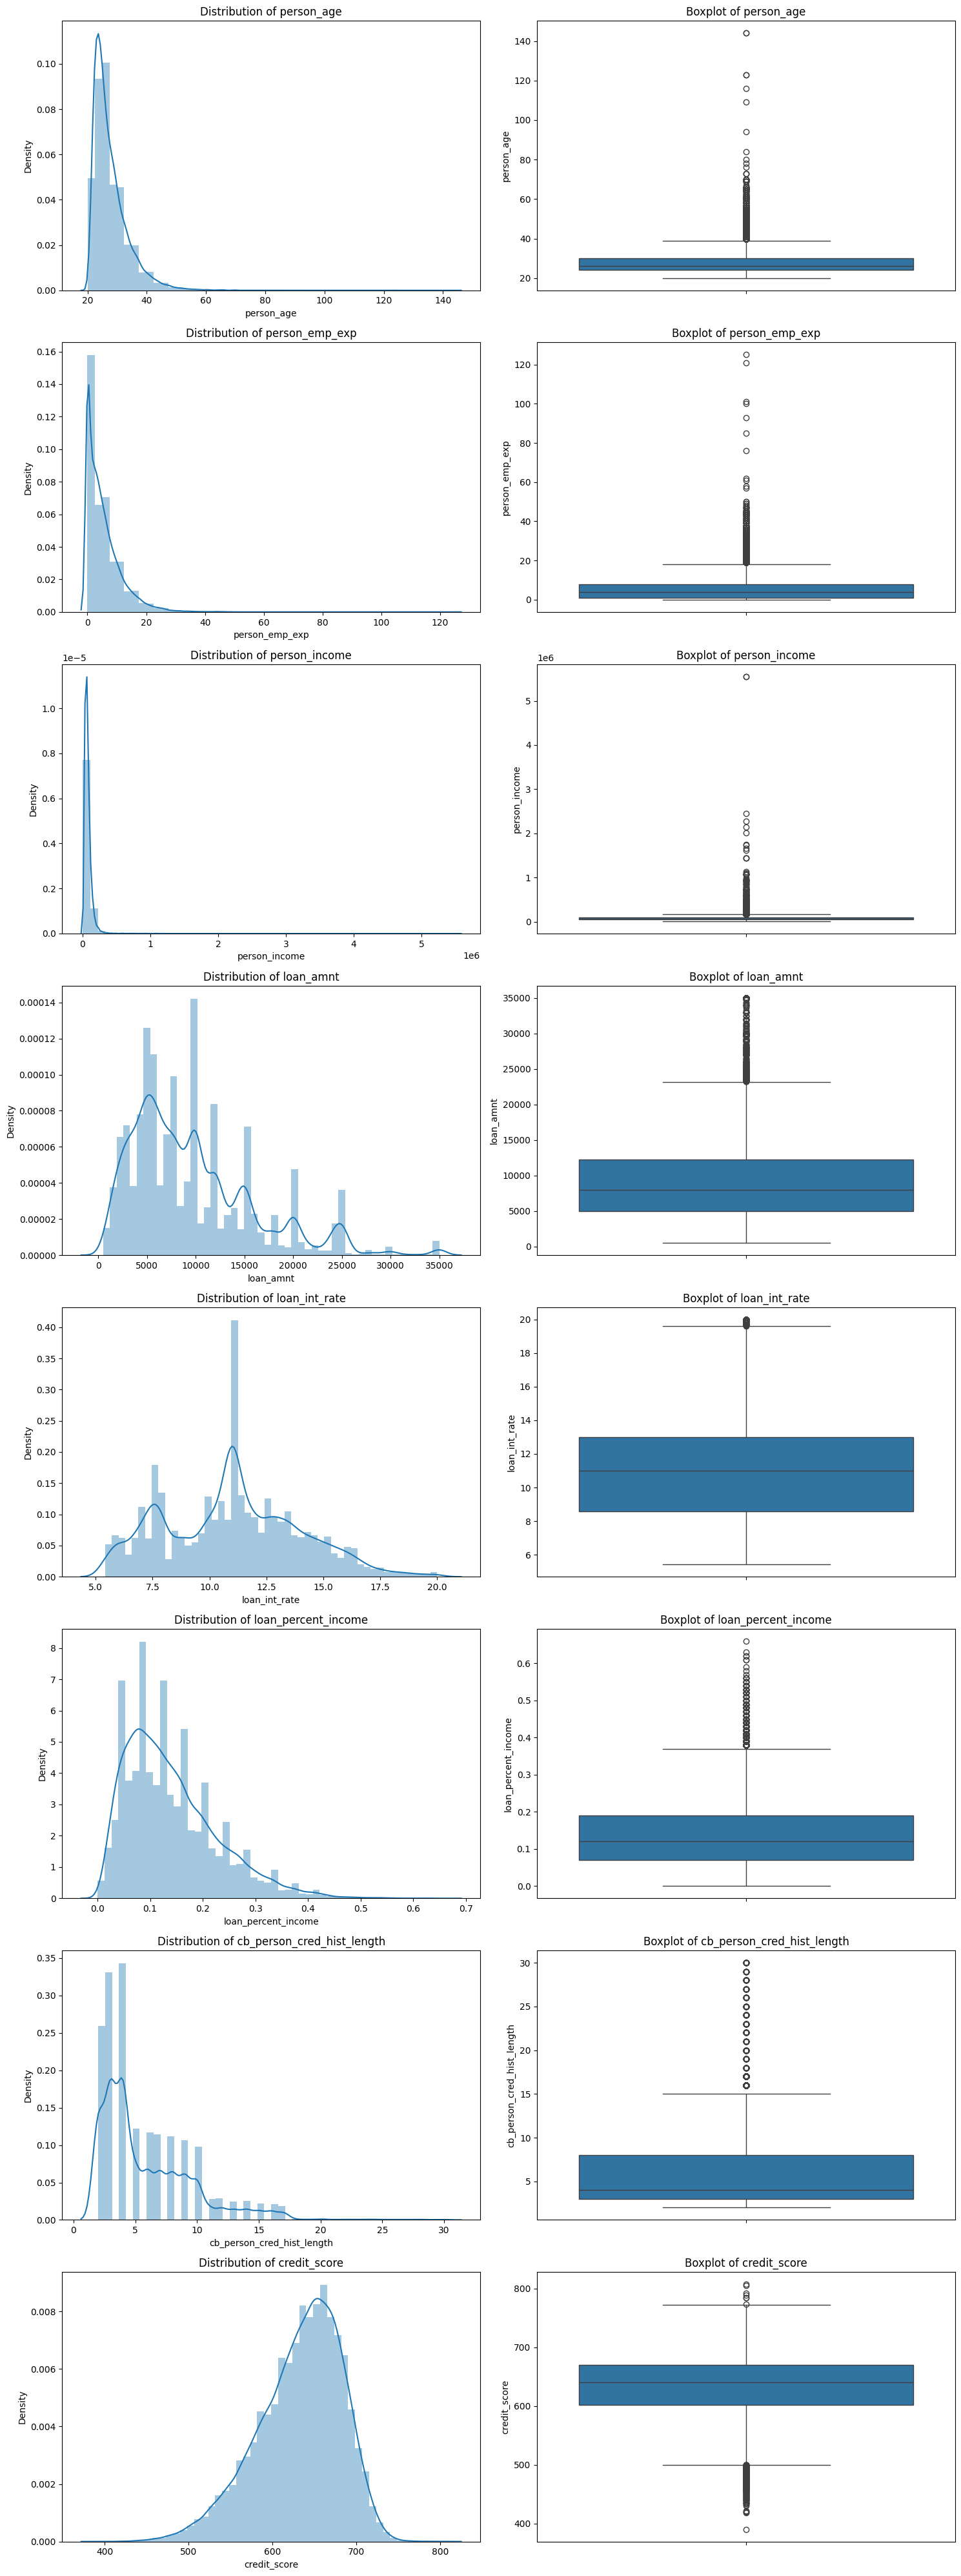

In [424]:
numerical_cols = ['person_age', 'person_emp_exp','person_income', 'loan_amnt', 'loan_int_rate',
                  'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=2, figsize=(15, 5*len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    sns.distplot(df[col], ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {col}')

    sns.boxplot(y=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()




*   Mengingat bahwa ini merupakan data customer yang disetujui maupun yg tidak disetujui, maka beberapa outlier yang ditemukan merupakan hal yang lumrah dan tidak diproses/diganti.
*   Distribusi data tidak setara dan ememang sudah benar, dikarenakan data ini menggunakan skala2 yang berbeda dan juga karena bervariasi pada setiap orangnya
*   Beberapa masalah yang masih perlu diselesaikan adalah person_experience dan person_age






**Pre-Processing**

Seperti yang sudah ditemukan pada EDA,

*   Person_Exp pada titik Max nya menyentuh nilai 125, yang dimana hal tersebut tidak mungkin terjadi di dunia nyata.
*   Person_age juga mencapai 144, dimana hal tersebut juga tidak mungkin kecuali menggunakan nama orang dengan umur tersebut.

Menggunakan Library Capper untuk membuat cap khususnya batas atas pada age dan juga experience


In [425]:
capper = ArbitraryOutlierCapper(
    max_capping_dict={
        'person_emp_exp': 55,
        'person_age': 70
    }
)
df_cap = capper.fit_transform(df)
df_cap

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22,female,Master,71948.0,0,RENT,35000,PERSONAL,16.02,0.49,3,561,No,1
1,21,female,High School,12282.0,0,OWN,1000,EDUCATION,11.14,0.08,2,504,Yes,0
2,25,female,High School,12438.0,3,MORTGAGE,5500,MEDICAL,12.87,0.44,3,635,No,1
3,23,female,Bachelor,79753.0,0,RENT,35000,MEDICAL,15.23,0.44,2,675,No,1
4,24,male,Master,66135.0,1,RENT,35000,MEDICAL,14.27,0.53,4,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27,male,Associate,47971.0,6,RENT,15000,MEDICAL,15.66,0.31,3,645,No,1
44996,37,female,Associate,65800.0,17,RENT,9000,HOMEIMPROVEMENT,14.07,0.14,11,621,No,1
44997,33,male,Associate,56942.0,7,RENT,2771,DEBTCONSOLIDATION,10.02,0.05,10,668,No,1
44998,29,male,Bachelor,33164.0,4,RENT,12000,EDUCATION,13.23,0.36,6,604,No,1


Encoding

In [426]:
bn = LabelBinarizer()
df_encoded = df_cap.copy()

binary_col = ['previous_loan_defaults_on_file','person_gender']
for col in binary_col:
    df_encoded[col] = bn.fit_transform(df_encoded[[col]])

cat_col = ['person_education', 'person_home_ownership', 'loan_intent']
df_encoded = pd.get_dummies(df_encoded, columns=cat_col, drop_first=True)
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df_encoded.head(5)

,person_age,person_gender,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,...,person_education_High School,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22,0,71948.0,0,35000,16.02,0.49,3,561,0,...,0,1,0,0,1,0,0,0,1,0
1,21,0,12282.0,0,1000,11.14,0.08,2,504,1,...,1,0,0,1,0,1,0,0,0,0
2,25,0,12438.0,3,5500,12.87,0.44,3,635,0,...,1,0,0,0,0,0,0,1,0,0
3,23,0,79753.0,0,35000,15.23,0.44,2,675,0,...,0,0,0,0,1,0,0,1,0,0
4,24,1,66135.0,1,35000,14.27,0.53,4,586,0,...,0,1,0,0,1,0,0,1,0,0


Splitting Data

In [427]:
x = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)


Scaling

In [428]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()



x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])

x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])


Random Forest Model

In [430]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=77)
rf_model.fit(x_train, y_train)

rf_pred = rf_model.predict(x_test)
rf_proba = rf_model.predict_proba(x_test)[:, 1]

In [441]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='error'
    )

xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)
xgb_proba = xgb_model.predict_proba(x_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:35:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Comparing 2 Models

In [442]:
print("XGBoost Classifier")
print(classification_report(y_test, xgb_pred))
print(f"ROC AUC: {roc_auc_score(y_test, xgb_proba):.4f}\n")

print("Random Forest Classifier")
print(classification_report(y_test, rf_pred))
print(f"ROC AUC: {roc_auc_score(y_test, rf_proba):.4f}")

XGBoost Classifier
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      6639
           1       0.89      0.77      0.82      1911

    accuracy                           0.93      8550
   macro avg       0.91      0.87      0.89      8550
weighted avg       0.93      0.93      0.92      8550

ROC AUC: 0.9752

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      6639
           1       0.90      0.76      0.82      1911

    accuracy                           0.93      8550
   macro avg       0.92      0.87      0.89      8550
weighted avg       0.93      0.93      0.93      8550

ROC AUC: 0.9739


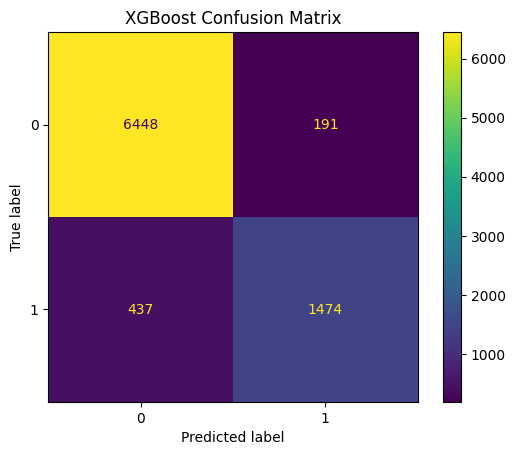

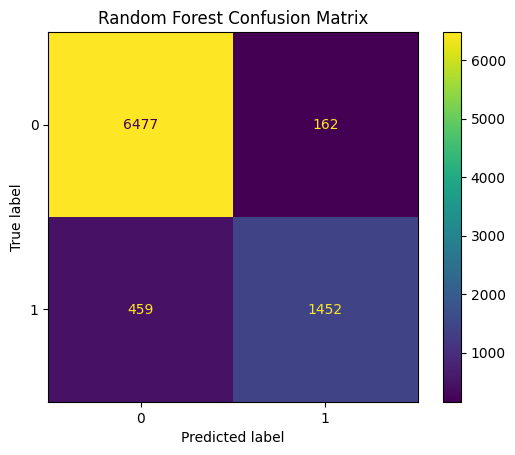

In [443]:
ConfusionMatrixDisplay.from_estimator(xgb_model, x_test, y_test)
plt.title("XGBoost Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(rf_model, x_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.show()

Meski hasil dari kedua model sangatlah mirip, namun disini dapat dinyatakan bahwa Modedl Xgboost memiliki model yang lebih biak. Hal tersebut dikarenakan oleh Nilai Recall dan Precision yang sedikit lebih tinggi menunjukan bahwa XGBoost memiliki model yang lebih baik untuk mengklasifikasi data untuk persetujuan pinjaman.

Export XGBoost Model into Pickle

In [444]:
import pickle as pkl
filename = 'xgb_class.pkl'
pkl.dump(rf_model,open(filename,'wb'))